In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS

### 1) Initialize Parameters

In [3]:
T = 100 # s, duration of time series
dt = 0.02 # s, time step
D_r = 300 # number of reservoir nodes
d = 6 # average degree of Erdos-Renyi network
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0 # regularization parameter
sigma = 0.1 # standard deviation of the input weights

### 2) Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\rho = 28$, $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [4]:
lorenz_pts = simulate_lorenz(dt=dt, T=T)

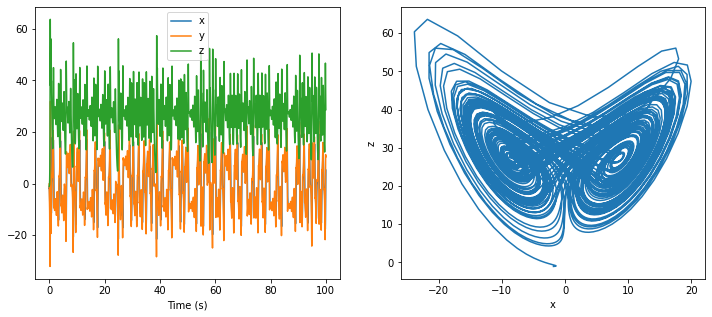

In [5]:
time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

### Build the Network

In [14]:
reservoir = ReservoirDS(lorenz_pts, dt=dt, D_r=D_r, d=d, rho=rho, beta=beta, sigma=sigma, squared_unit_input_dims=[2])

The average degree of the network is 6.03


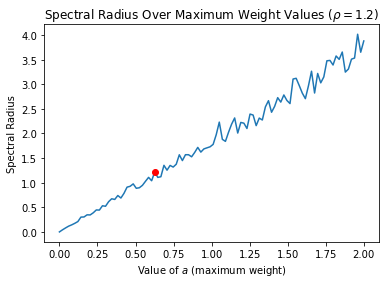

The spectral radius is 1.219


In [15]:
reservoir.build_connectivity(debug=True)

In [16]:
reservoir.train()

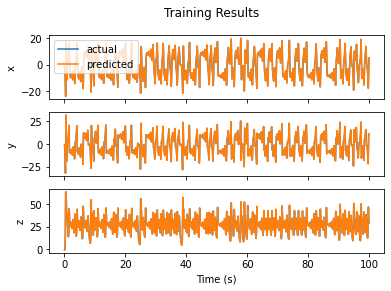

In [17]:
reservoir.print_train_results()

In [18]:
reservoir.test(25)

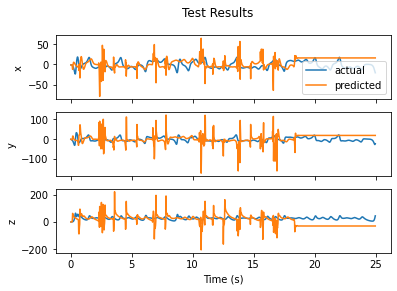

In [19]:
reservoir.print_test_results()

In [37]:
def sech(x):
    return 1/np.cosh(x)

def jacobian(reservoir):
    J = np.zeros((reservoir.u.shape[0], reservoir.D_r, reservoir.D_r))
    D_mat = np.zeros((reservoir.D_r, reservoir.D_r))
    
    # 0th step
    D_mat[np.arange(reservoir.D_r)] = sech(reservoir.A@reservoir.r_init)**2
    J[0] = D_mat @ reservoir.A
    
    for t in range(reservoir.u.shape[0] - 1):
        D_mat[np.arange(reservoir.D_r)] = sech(reservoir.A@reservoir.r_train[t] + reservoir.W_in@reservoir.u[t])**2
        J[t+1] = D_mat @ reservoir.A
        
    return J

In [38]:
J = jacobian(reservoir)

In [40]:
def lyap_spectrum_QR(Js,T):
    K,n = Js.shape[0],Js.shape[-1]    
    Q,R = np.linalg.qr(Js[0])
    lyaps = np.zeros((n,))

    for t in range(1,K):
        Q = Js[t] @ Q
        

        # Need diagonal of R to be positive, so rewrite Q = Q @ S and R = S @ R, where S_ii = sign(R_ii)
        S = np.diag(np.sign(np.diag(R)))
        lyaps += np.log(np.diag(S @ R))
        
        Q = Q @ S

        #add diagonal of R to running lyapunov spectrum estimate
        
        Q,R = np.linalg.qr(Q)

    lyaps /= T
    
    return lyaps

In [43]:
lyaps = lyap_spectrum_QR(J[1:],reservoir.T)
print(lyaps)

<ipython-input-40-7e1a21a31cdb>:12: RuntimeWarning: divide by zero encountered in log
  lyaps += np.log(np.diag(S @ R))


[   106.63818821  -1726.07141616  -3492.58334268  -5316.80592121
  -7090.9677491   -8891.63916637 -10630.04585531 -12388.25415924
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf         